# Predicting raindfall for World Food Program

Technical Test | Data Scientist Junior Consultant | June 2020

Rainfall is an important factor affecting people's livelihoods: if it deviates from the season's averages it can impact agricultural production. Rainfall therefore is an important data stream that we use in WFP to monitor food security.

The aim of this assessment is to evaluate your data science skills. You will have to train a model(s) that predicts rainfall in a given region given historical rainfall estimates. We are providing you with a dataset with rainfall estimates in a number of regions worldwide indexed by region (AdminCode), year, month and decade (one month is made of 3 decades). Your model(s) should be able to predict the rainfall per region for the next 3 decades (i.e. t+1, t+2, t+3).

You can fetch the data from:
https://wfp-public.oss-eu-central-1.aliyuncs.com/tmp/rainfall_by_country.csv. 

Please do your work in python using a Jupyter Notebook with comments and submit that.

Please note that we are more interested in your methodology (model choice, hyperparameters tuning, evaluation/validation) rather than the model's accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random

#Supress default INFO logging
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [2]:
data = pd.read_csv('rainfall_by_country.csv')

In [3]:
data.head()

,AdminCode,mean_rainfall,year,month,decade
0,273,1.613,1990,1,1
1,274,103.433,1990,1,1
2,276,140.389,1990,1,1
3,277,61.144,1990,1,1
4,278,0.000,1990,1,1


In [4]:
data['day'] = data['decade'] * 10 - 9

In [5]:
data['date'] = pd.to_datetime(data['year'].astype(str) + data['month'].astype(str).str.zfill(2) + data['day'].astype(str).str.zfill(2))

In [6]:
data.head()

,AdminCode,mean_rainfall,year,month,decade,day,date
0,273,1.613,1990,1,1,1,1990-01-01
1,274,103.433,1990,1,1,1,1990-01-01
2,276,140.389,1990,1,1,1,1990-01-01
3,277,61.144,1990,1,1,1,1990-01-01
4,278,0.000,1990,1,1,1,1990-01-01


In [7]:
data['date'].unique()[:5]

array(['1990-01-01T00:00:00.000000000', '1990-01-11T00:00:00.000000000',
       '1990-01-21T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-02-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
data.describe()

,AdminCode,mean_rainfall,year,month,decade,day
count,265620.000000,265620.000000,265620.000000,265620.000000,265620.000000,265620.000000
mean,3509.388344,32.397389,2004.496725,6.499548,1.999910,10.999096
std,18051.579411,40.552156,8.653691,3.452277,0.816517,8.165166
min,1.000000,-1.000000,1990.000000,1.000000,1.000000,1.000000
25%,75.000000,5.188000,1997.000000,3.000000,1.000000,1.000000
50%,162.000000,18.000000,2004.000000,6.000000,2.000000,11.000000
75%,243.000000,44.611500,2012.000000,10.000000,3.000000,21.000000
max,147299.000000,668.000000,2019.000000,12.000000,3.000000,21.000000


Why are there several rows with negative mean rainfall? How is that possible?

In [9]:
data[data['mean_rainfall'] < 0]

,AdminCode,mean_rainfall,year,month,decade,day,date
122,134,-1.0,1990,1,1,1,1990-01-01
189,216,-1.0,1990,1,1,1,1990-01-01
344,134,-1.0,1990,1,2,11,1990-01-11
411,216,-1.0,1990,1,2,11,1990-01-11
614,134,-1.0,1990,1,3,21,1990-01-21
...,...,...,...,...,...,...,...
265050,216,-1.0,2019,12,1,1,2019-12-01
265228,134,-1.0,2019,12,2,11,2019-12-11
265295,216,-1.0,2019,12,2,11,2019-12-11
265473,134,-1.0,2019,12,3,21,2019-12-21


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265620 entries, 0 to 265619
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   AdminCode      265620 non-null  int64         
 1   mean_rainfall  265620 non-null  float64       
 2   year           265620 non-null  int64         
 3   month          265620 non-null  int64         
 4   decade         265620 non-null  int64         
 5   day            265620 non-null  int64         
 6   date           265620 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 14.2 MB


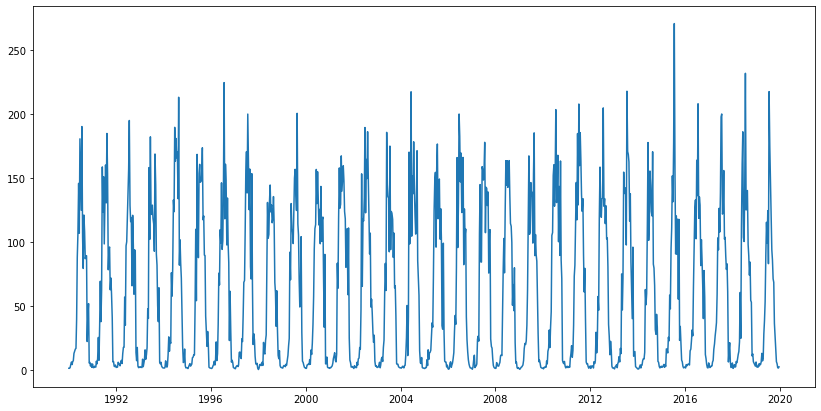

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == 273]['date'], data[data['AdminCode'] == 273]['mean_rainfall'])
plt.show()

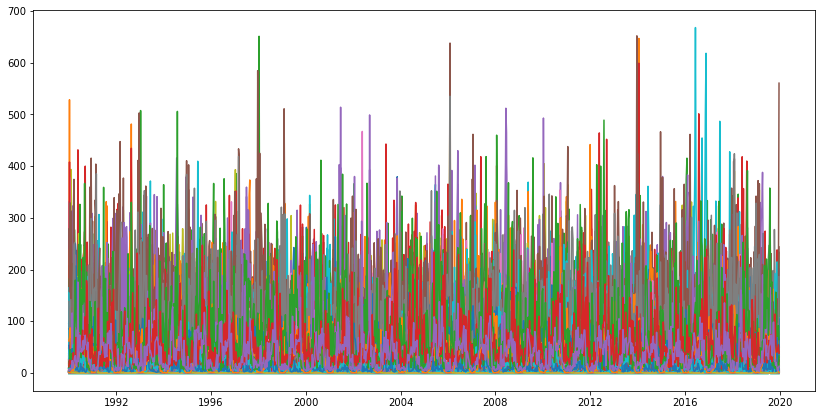

In [12]:
plt.figure(figsize=(14, 7))
for code in data['AdminCode'].unique():
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] == code]['mean_rainfall'])
plt.show()

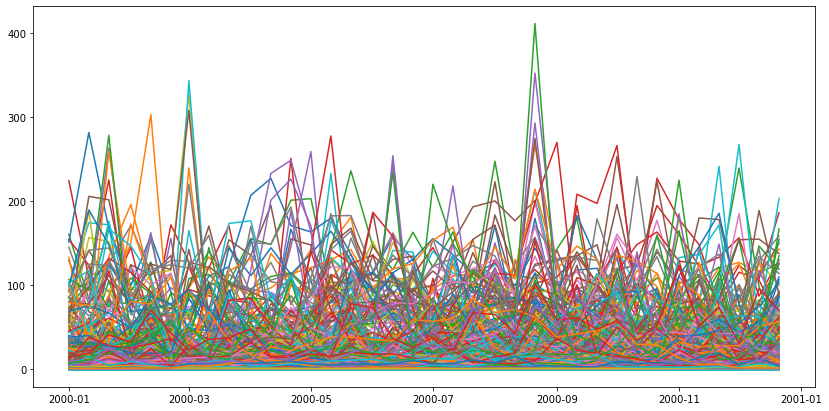

In [13]:
data2000 = data[data['date'].dt.year == 2000]
plt.figure(figsize=(14, 7))
for code in data2000['AdminCode'].unique():
    plt.plot(data2000[data2000['AdminCode'] == code]['date'], data2000[data2000['AdminCode'] == code]['mean_rainfall'])
plt.show()

In [14]:
df = pd.DataFrame()
df['ds'] = data['date']
df['y'] = data['mean_rainfall']
# df['cap'] = 15000
df['floor'] = 0  # only used if growth='logistic'

In [15]:
code = 273

prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=4,
                                    prior_scale=10,
                                    mode='additive'
                  )

In [16]:
prophet.fit(df[data['AdminCode'] == code])

In [17]:
future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

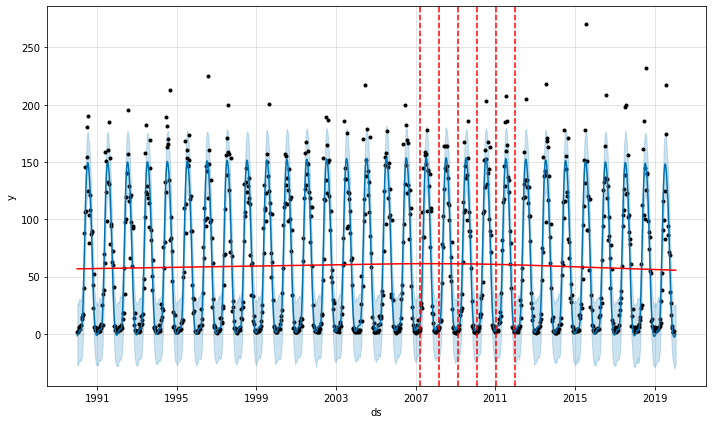

In [18]:
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

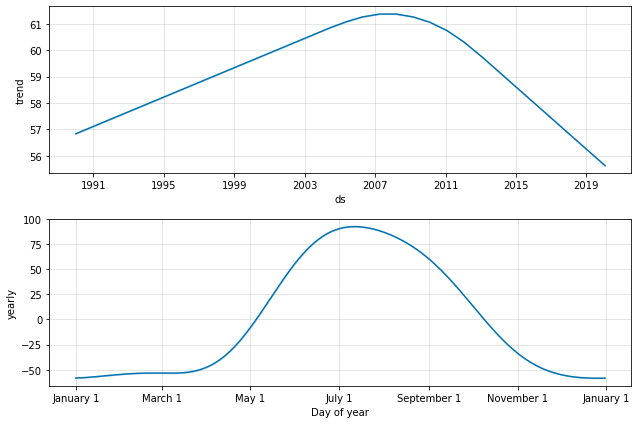

In [19]:
fig2 = prophet.plot_components(forecast)
plt.show()

In [20]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [21]:
len(cutoffs)

228

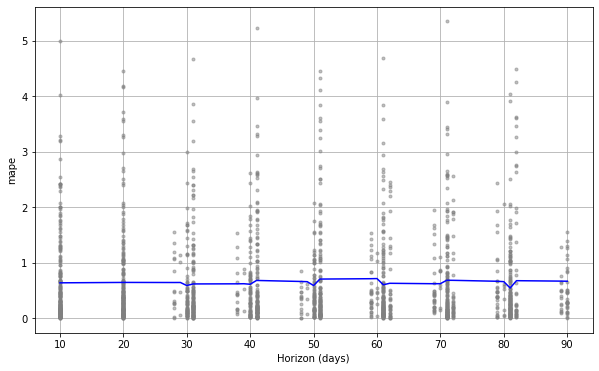

mape: 64.24%


In [22]:
df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '90 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

### Hyperparameter tuning

In [23]:
def run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode):
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=changepoint_prior_scale
                     ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=fourier_order,
                                        prior_scale=prior_scale,
                                        mode=mode
                                        )
    
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    future = prophet.make_future_dataframe(periods=31, freq='D')
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

    forecast = prophet.predict(future)
    
    cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))
    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '90 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
    
    rmse = df_p['rmse'].mean()
    print('rmse:', '{:.2f}'.format(rmse))
    return rmse

In [24]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=4, prior_scale=10, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C4D788>


rmse: 21.41


21.406618279204974

In [25]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=4, prior_scale=10, mode='multiplicative')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C4D288>


rmse: 21.46


21.457128093976372

In [26]:
run_model(admin_code=273, changepoint_prior_scale=.01, fourier_order=4, prior_scale=10, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C5E408>


rmse: 21.46


21.464367342343326

In [27]:
run_model(admin_code=273, changepoint_prior_scale=.15, fourier_order=4, prior_scale=10, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F133C8>


rmse: 21.45


21.450069503915763

In [28]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=6, prior_scale=10, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B00038F88>


rmse: 21.18


21.184701696556438

In [29]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=8, prior_scale=10, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A06288>


rmse: 21.14


21.143591040645248

In [30]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=4, prior_scale=30, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B7A2FB648>


rmse: 21.41


21.405741475670734

In [31]:
run_model(admin_code=273, changepoint_prior_scale=.05, fourier_order=4, prior_scale=1, mode='additive')

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A863C8>


rmse: 21.41


21.40664519933282

### Grid search hyperparameters with random sample of admin codes

In [34]:
results = {}

# admin_codes = [1, 273, 274, 278, 147299]
admin_codes = random.sample(data['AdminCode'].unique().tolist(), 5)

changepoint_prior_scales = [.05]  # [.01, .05, .15]
fourier_orders = [4]  # [4, 6, 8]
prior_scales = [10]  # [1, 10, 30]
modes = ['multiplicative']  # ['multiplicative', 'additive']

for admin_code in admin_codes:
    results[admin_code] = []
    for changepoint_prior_scale in changepoint_prior_scales:
        for fourier_order in fourier_orders:
            for prior_scale in prior_scales:
                for mode in modes:
                    params = {'admin_code': admin_code,
                              'changepoint_prior_scale': changepoint_prior_scale,
                              'fourier_order': fourier_order,
                              'prior_scale': prior_scale,
                              'mode': mode}
#                     print(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    print(params)
#                     rmse = run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    rmse = run_model(**params)
                    results[admin_code].append((rmse, params))
                    print()

{'admin_code': 245, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B7A304388>


rmse: 44.53

{'admin_code': 221, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A78B48>


rmse: 28.20

{'admin_code': 208, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05E09A48>


rmse: 22.20

{'admin_code': 191, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A7BF48>


rmse: 28.68

{'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A41088>


rmse: 31.38



In [36]:
for admin_code in results:
    best_model = sorted(results[admin_code], key=lambda x: x[0])[0]
    print(admin_code, 'best parameters:', best_model)

245 best parameters: (44.528695653415404, {'admin_code': 245, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})
221 best parameters: (28.19787232753928, {'admin_code': 221, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})
208 best parameters: (22.20114922303821, {'admin_code': 208, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})
191 best parameters: (28.677194231537214, {'admin_code': 191, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})
260 best parameters: (31.380406823923124, {'admin_code': 260, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})


In [47]:
for admin_code in results:
    print('{} RMSE: {:.2f}, mean rainfall: {:.2f}'.format(admin_code,
                                                          sorted(results[admin_code], key=lambda x: x[0])[0][0],
                                                          data[data['AdminCode'] == admin_code].groupby('AdminCode')['mean_rainfall'].mean().values[0]))

245 RMSE: 44.53, mean rainfall: 52.91
221 RMSE: 28.20, mean rainfall: 71.39
208 RMSE: 22.20, mean rainfall: 23.12
191 RMSE: 28.68, mean rainfall: 78.45
260 RMSE: 31.38, mean rainfall: 36.14


### Create forecasts for all admin codes

In [48]:
def make_prophet_model(data, admin_code):
    
    data = data[data['AdminCode'] == admin_code]
    df = pd.DataFrame()
    df['ds'] = data['date']
    df['y'] = data['mean_rainfall']
    
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    return prophet

In [49]:
forecast_df = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])

In [50]:
models = {}

In [51]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [ ]:
codes = data['AdminCode'].unique()
codes = [code for idx, code in enumerate(codes) if idx % 5 == 0]  # for testing

counter = 0
total = len(codes)

for code in codes:
    if counter % 10 == 0:
        print('Processing {} / {}'.format(counter + 1, total))
    counter += 1
#     print()
#     print('Admin Code: {}'.format(code))
    # Make Prophet model
    prophet = make_prophet_model(data, code)
    
    # Make future DataFrame with 31 day forecast
    future = prophet.make_future_dataframe(periods=31, freq='D')
    # Remove all days except 01, 11, 21 (the "decades")
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]
    
    # Create forecast
    forecast = prophet.predict(future)
    
    # Plot forecast components
#     fig2 = prophet.plot_components(forecast)
#     plt.show()

    # Save the forecast for the next 3 decades
    output = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])
    output['forecast_rainfall'] = forecast.tail(3)['yhat'].clip(lower=0)
    output['forecast_rainfall_lower_ci'] = forecast.tail(3)['yhat_lower']
    output['forecast_rainfall_upper_ci'] = forecast.tail(3)['yhat_upper']
    output['year'] = forecast.tail(3)['ds'].dt.year
    output['month'] = forecast.tail(3)['ds'].dt.month
    output['decade'] = forecast.tail(3)['ds'].dt.day.astype(str).str.zfill(2).str[-2].astype(int) + 1
    output['AdminCode'] = code
    forecast_df = pd.concat([forecast_df, output])

    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '31 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
#     fig = plot_cross_validation_metric(df_cv, metric='mape')
#     plt.show()
#     print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))
    models[code] = (df_p['rmse'].mean(), prophet, df_cv, df_p)

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F154C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B0838E888>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B070DD8C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05DD99C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06ACB608>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06B08B88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06BEAE88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

Processing 10 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05E09148>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F72408>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06C19C88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F43808>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B068FC508>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B08385A88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A5A388>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06BDF188

Processing 20 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B0702F688>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B083A4988>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A5D7C8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06AFFD08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06A61A48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B05E0DAC8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000020B06F0BD88>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

In [ ]:
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][0]

In [ ]:
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][-1]

In [ ]:
forecast_df

In [ ]:
code = 147299

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

df_cv = cross_validation(prophet, horizon = '31 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [ ]:
code = 1

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

df_cv = cross_validation(prophet, horizon = '31 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [ ]:
df_cv

In [ ]:
data[data['mean_rainfall'] == data['mean_rainfall'].max()]['AdminCode'].values[0]

In [ ]:
code = data[data['mean_rainfall'] == data['mean_rainfall'].max()]['AdminCode'].values[0]

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

df_cv = cross_validation(prophet, horizon = '31 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

In [ ]:
df_cv

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == 54]['date'], data[data['AdminCode'] == 54]['mean_rainfall'])
plt.show()